# Time Series Model Development Tutorial 

## Setup ValidMind Platform
Prepare the environment for our analysis. First, **import** all necessary libraries and modules required for our analysis. Next, **connect** to the ValidMind MRM platform, which provides a comprehensive suite of tools and services for model validation.

Finally, define and **configure** the specific use case we are working on by setting up any required parameters, data sources, or other settings that will be used throughout the analysis.

### ValidMind Project Information
**Model**: FRED Loan Rates  
**Project Type**: Initial Validation   
**Project ID**: `clhuctiea0000j3y6fkeyk73f`  
**Template**: `time_series_forecasting_v3.yaml` 

### Import Libraries

In [1]:
# Load API key and secret from environment variables
%load_ext dotenv
%dotenv .env

# Load ValidMind utils  
from validmind.datasets.regression import (
    identify_frequencies, 
    resample_to_common_frequency
)

### Connect to ValidMind Project

In [2]:

import validmind as vm

vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  api_key = "2494c3838f48efe590d531bfe225d90b",
  api_secret = "4f692f8161f128414fef542cab2a4e74834c75d01b3a8e088a1834f2afcfe838",
  project = "clhuctiea0000j3y6fkeyk73f"
)
  

Connected to ValidMind. Project: [2] FRED Loan Rates Model - Initial Validation (clhuctiea0000j3y6fkeyk73f)


True

### Test Plans Availables

In [3]:
vm.test_plans.list_plans()

ID,Name,Description
binary_classifier_metrics,BinaryClassifierMetrics,Test plan for sklearn classifier metrics
binary_classifier_validation,BinaryClassifierPerformance,Test plan for sklearn classifier models
binary_classifier_model_diagnosis,BinaryClassifierDiagnosis,Test plan for sklearn classifier model diagnosis tests
tabular_dataset_description,TabularDatasetDescription,Test plan to extract metadata and descriptive statistics from a tabular dataset
tabular_data_quality,TabularDataQuality,Test plan for data quality on tabular datasets
time_series_data_quality,TimeSeriesDataQuality,Test plan for data quality on time series datasets
time_series_univariate,TimeSeriesUnivariate,Test plan to perform time series univariate analysis.
time_series_multivariate,TimeSeriesMultivariate,Test plan to perform time series multivariate analysis.
time_series_forecast,TimeSeriesForecast,Test plan to perform time series forecast tests.
time_series_sensitivity,TimeSeriesSensitivity,Test plan to perform time series forecast tests.


## Data Engineering 

### Data Collection

In [4]:
from validmind.datasets.regression import fred as demo_dataset

target_column = demo_dataset.target_column
feature_columns = demo_dataset.feature_columns

# Split the dataset into test and training 
df = demo_dataset.load_data()

### Connect Datasets to ValidMind Platform

In [5]:
vm_dataset = vm.init_dataset(
    dataset=df,
    target_column=demo_dataset.target_column,
)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


### Data Description

### Data Quality

**Run the Time Series Data Quality Test Plan**

In [6]:
# TIME SERIES DATA QUALITY PARAMS
config={
    
    "time_series_outliers": {
        "zscore_threshold": 3,
    },
    "time_series_missing_values":{
        "min_threshold": 2,
    }
}

# vm.run_test_plan("time_series_data_quality",
#                 config=config, 
#                 dataset=vm_dataset)

## Exploratory Data Analysis

### Univariate Analysis

**Run the Time Series Univariate Test Plan**

In [7]:
# TIME SERIES UNIVARIATE PARAMS 
config={
       
    "rolling_stats_plot": {
        "window_size": 12    
    },
     "seasonal_decompose": {
        "seasonal_model": 'additive'
    },
     "auto_seasonality": {
        "min_period": 1,
        "max_period": 3
    },
      "auto_stationarity": {
        "max_order": 3,
        "threshold": 0.05
    },
    "auto_ar": {
        "max_ar_order": 4
    },
    "auto_ma": {
        "max_ma_order": 3
    }
}

# vm.run_test_plan("time_series_univariate",
#                config=config, 
#                 dataset=vm_dataset)

### Multivariate Analysis

**Run the Time Series Univariate Test Plan**

In [8]:
# TIME SERIES MULTIVARIATE PARAMS 
config={

    "lagged_correlation_heatmap": {
        "target_col": demo_dataset.target_column,
        "independent_vars": demo_dataset.feature_columns
    },
    "engle_granger_coint": {
        "threshold": 0.05
    },
}

# vm.run_test_plan("time_series_multivariate",
#                 config=config, 
#                 dataset=vm_dataset)

## Feature Engineering

### Treatment of Frequencies
Show the frequencies of each variable in the raw dataset.

In [9]:
frequencies = identify_frequencies(df)
display(frequencies)

,Variable,Frequency
0,MORTGAGE30US,None
1,FEDFUNDS,MS
2,GS10,MS
3,UNRATE,MS


Handle frequencies by resampling all variables to a common frequency.

In [10]:
preprocessed_df = resample_to_common_frequency(df, common_frequency=demo_dataset.frequency)
frequencies = identify_frequencies(preprocessed_df)
display(frequencies)

,Variable,Frequency
0,MORTGAGE30US,MS
1,FEDFUNDS,MS
2,GS10,MS
3,UNRATE,MS


**Run the Time Series Dataset Test Suite**

Run the same suite again after handling frequencies. 

In [11]:
vm_dataset = vm.init_dataset(
    dataset=preprocessed_df,
    target_column=demo_dataset.target_column,
)

full_suite = vm.run_test_suite(
    "time_series_dataset",
    dataset=vm_dataset,
)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


Frequency of MORTGAGE30US: MS
Frequency of FEDFUNDS: MS
Frequency of GS10: MS
Frequency of UNRATE: MS


iteritems is deprecated and will be removed in a future version. Use .items instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
The frame.append method is deprecated and will be removed from pandas in a future vers

### Treatment of Missing Values
Handle the missing values by droping all the `nan` values.

In [12]:
preprocessed_df = preprocessed_df.dropna()

**Run the Time Series Dataset Test Suite**

Run the same test suite to check there are no missing values and frequencies of all variables are the same.

In [13]:
vm_dataset = vm.init_dataset(
    dataset=preprocessed_df,
    target_column=demo_dataset.target_column,
)

full_suite = vm.run_test_suite(
    "time_series_dataset",
    dataset=vm_dataset,
)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


Frequency of MORTGAGE30US: MS
Frequency of FEDFUNDS: MS
Frequency of GS10: MS
Frequency of UNRATE: MS


iteritems is deprecated and will be removed in a future version. Use .items instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
The frame.append method is deprecated and will be removed from pandas in a future vers

## Model Training

### Load Train Data, Test Data and Models

In [14]:
# Currently only fred pre-trained models are available
from validmind.datasets.regression import fred as demo_dataset
model_A, train_df_A, test_df_A = demo_dataset.load_model('fred_loan_rates_model_3')
model_B, train_df_B, test_df_B = demo_dataset.load_model('fred_loan_rates_model_4')

### Create ValidMind Datasets

In [15]:
# Initialize training and testing datasets for model A
vm_train_ds_A = vm.init_dataset(dataset=train_df_A, type="generic", target_column=demo_dataset.target_column)
vm_test_ds_A = vm.init_dataset(dataset=test_df_A, type="generic", target_column=demo_dataset.target_column)

# Initialize training and testing datasets for model B
vm_train_ds_B = vm.init_dataset(dataset=train_df_B, type="generic", target_column=demo_dataset.target_column)
vm_test_ds_B = vm.init_dataset(dataset=test_df_B, type="generic", target_column=demo_dataset.target_column)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...
Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...
Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...
Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


### Create ValidMind Models

In [16]:
# Initialize model A
vm_model_A = vm.init_model(
    model = model_A, 
    train_ds=vm_train_ds_A, 
    test_ds=vm_test_ds_A)

# Initialize model B
vm_model_B = vm.init_model(
    model = model_B,
    train_ds=vm_train_ds_B,
    test_ds=vm_test_ds_B)


list_of_models = [vm_model_A, vm_model_B]

### Data Split Description

**Run the Regression Model Description Test Plan**

In [17]:
test_plan = vm.run_test_plan(
    "regression_model_description",
    model = vm_model_B,
    models = list_of_models
)

### Train and Test Data Validation

In [18]:
#vm.test_plans.describe_plan("time_series_data_quality")

In [19]:
#vm.test_plans.describe_plan("time_series_univariate")

In [20]:
#vm.test_plans.describe_plan("time_series_multivariate")

In [21]:
vm_dataset = vm.init_dataset(
    dataset=train_df_B,
    target_column=demo_dataset.target_column,
)

# full_suite = vm.run_test_suite(
#    "time_series_dataset",
#    dataset=vm_dataset,
#)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


In [22]:
vm_dataset = vm.init_dataset(
    dataset=test_df_B,
    target_column=demo_dataset.target_column,
)

full_suite = vm.run_test_suite(
    "time_series_dataset",
    dataset=vm_dataset,
)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


Frequency of MORTGAGE30US: MS
Frequency of GS10: MS
Frequency of FEDFUNDS: MS


iteritems is deprecated and will be removed in a future version. Use .items instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version

## Model Testing

### Performance

**Run the Regression Model Evaluation Test Plan**

In [23]:
test_plan = vm.run_test_plan(
    "regression_models_evaluation",
    model = model_B,
    models = list_of_models
)

### Forecasting

**Run the Time Series Forecast Test Plan**

In [24]:
config= {
    "regression_forecast_plot_levels": {
        "transformation": "integrate",
    }
}

test_plan = vm.run_test_plan(
    "time_series_forecast",
    models = list_of_models,
    config = config
)

{'transformation': 'integrate'}


### Sensitivity Analysis 

In [25]:
def apply_shock(df, shocks, target_col):
    shocked_dfs = [df.copy()]  # Start with the original dataset
    cols_to_shock = df.columns.drop(target_col)  # All columns except target

    # apply shock one variable at a time
    for shock in shocks:
        for col in cols_to_shock:
            temp_df = df.copy()
            temp_df[col] = temp_df[col] * (1 + shock)
            shocked_dfs.append(temp_df)
    
    return shocked_dfs

In [26]:
# Assuming df_test is your test dataset and you want to apply shocks of 5% and 10%
shocks = [0.10]
shocked_test_df_B = apply_shock(test_df_B,
                                shocks=shocks,
                                target_col = demo_dataset.target_column)
shocked_test_df_B

[            MORTGAGE30US  GS10  FEDFUNDS
 DATE                                    
 2012-12-01          0.03  0.07      0.00
 2013-01-01          0.18  0.19     -0.02
 2013-02-01         -0.02  0.07      0.01
 2013-03-01          0.06 -0.02     -0.01
 2013-04-01         -0.17 -0.20      0.01
 ...                  ...   ...       ...
 2022-11-01         -0.50 -0.09      0.70
 2022-12-01         -0.16 -0.27      0.32
 2023-01-01         -0.29 -0.09      0.23
 2023-02-01          0.37  0.22      0.24
 2023-03-01         -0.18 -0.09      0.08
 
 [124 rows x 3 columns],
             MORTGAGE30US   GS10  FEDFUNDS
 DATE                                     
 2012-12-01          0.03  0.077      0.00
 2013-01-01          0.18  0.209     -0.02
 2013-02-01         -0.02  0.077      0.01
 2013-03-01          0.06 -0.022     -0.01
 2013-04-01         -0.17 -0.220      0.01
 ...                  ...    ...       ...
 2022-11-01         -0.50 -0.099      0.70
 2022-12-01         -0.16 -0.297      0.

{'transformation': 'integrate'}
            GS10
DATE            
1971-05-01  0.56
1971-06-01  0.13
1971-07-01  0.21
1971-08-01 -0.15
1971-09-01 -0.44
...          ...
2012-06-01 -0.18
2012-07-01 -0.09
2012-08-01  0.15
2012-09-01  0.04
2012-10-01  0.03

[498 rows x 1 columns]


KeyError: 0

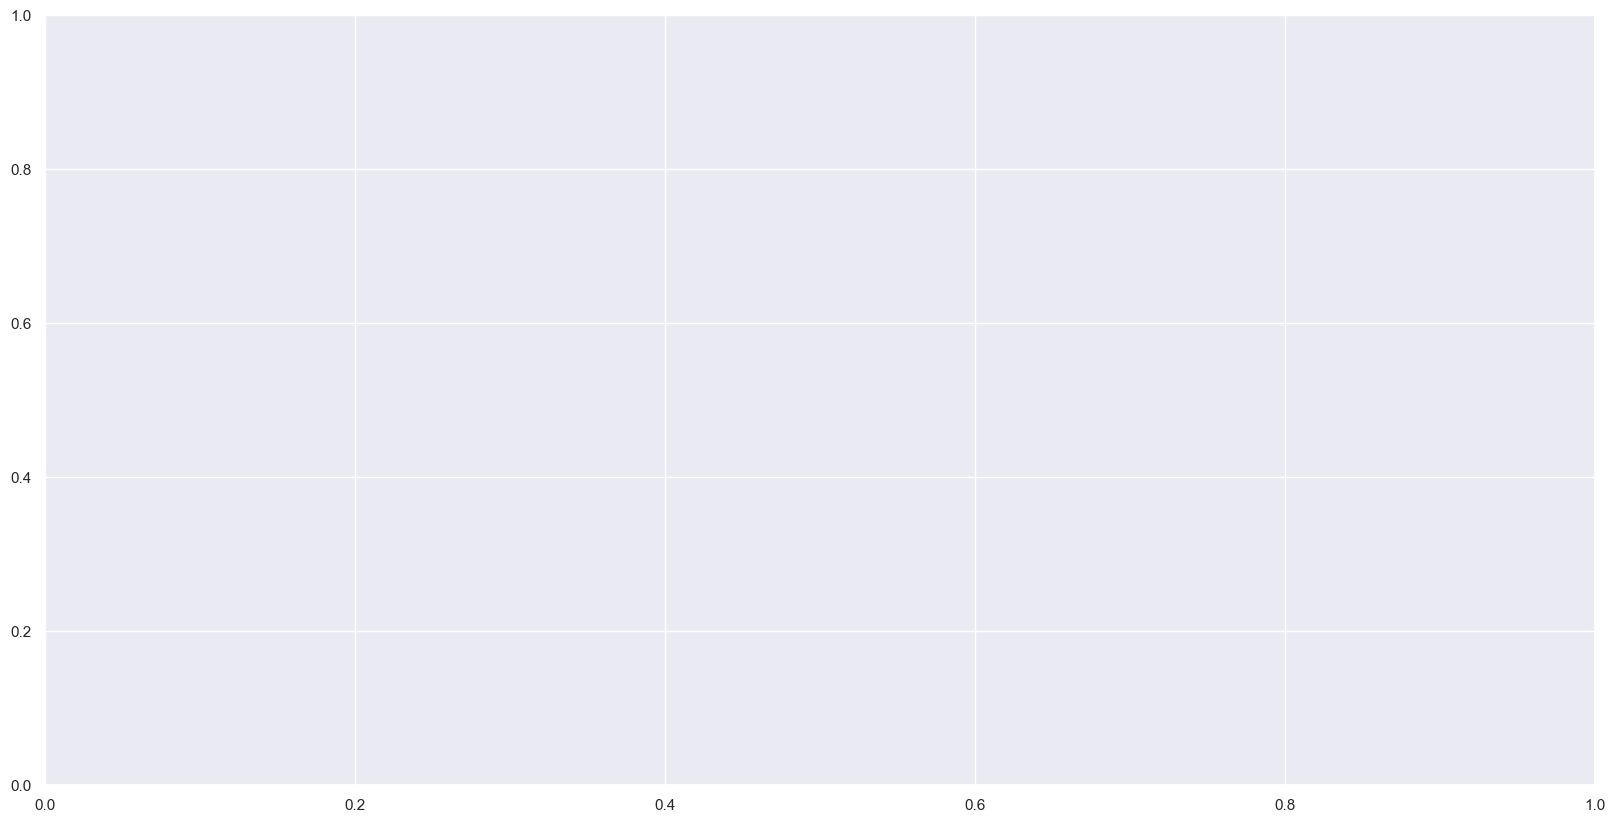

In [27]:
config= {
    "regression_sensitivity_plot": {
        "transformation": "integrate",
    }
}

test_plan = vm.run_test_plan(
    "time_series_sensitivity",
    models = list_of_models,
    config = config
)